## A/B Tesing : Impact of Social Proof Badge on Food Delivery Orders


* Evaluate whether displaying a social-proof badge increases order conversion
without negatively impacting order quality.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chisquare


In [ ]:
from google.colab import files
uploaded = files.upload()



Saving ab_testing.csv to ab_testing.csv


In [ ]:
df = pd.read_csv("ab_testing.csv")

df.head()


,user_id,date,variant,ordered,menu_clicks,order_cancelled,time_to_order,order_value
0,D0_U00000,01-12-2025,control,0,7,0,NaN,0.0
1,D0_U00001,01-12-2025,control,0,6,0,NaN,0.0
2,D0_U00002,01-12-2025,control,0,2,0,NaN,0.0
3,D0_U00003,01-12-2025,treatment,0,3,0,NaN,0.0
4,D0_U00004,01-12-2025,control,0,1,0,NaN,0.0


In [ ]:
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

### Data Quality & Sanity Checks

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56627 entries, 0 to 56626
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          56627 non-null  object 
 1   date             56627 non-null  object 
 2   variant          56627 non-null  object 
 3   ordered          56627 non-null  int64  
 4   menu_clicks      56627 non-null  int64  
 5   order_cancelled  56627 non-null  int64  
 6   time_to_order    11636 non-null  float64
 7   order_value      56627 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 3.5+ MB


In [ ]:
df.isna().mean().sort_values(ascending=False)


,0
time_to_order,0.794515
user_id,0.000000
variant,0.000000
date,0.000000
ordered,0.000000
menu_clicks,0.000000
order_cancelled,0.000000
order_value,0.000000


In [ ]:
df.groupby('date')['user_id'].count()

,user_id
date,
01-12-2025,5972
02-12-2025,6054
03-12-2025,5911
04-12-2025,6022
05-12-2025,6991
06-12-2025,6815
07-12-2025,6852
08-12-2025,5985
09-12-2025,6025


##EDA

In [ ]:
df.groupby('variant')['ordered'].mean()


,ordered
variant,
control,0.200509
treatment,0.210458


In [ ]:
pd.crosstab(df['variant'], df['ordered'], normalize='index')

ordered,0,1
variant,,
control,0.799491,0.200509
treatment,0.789542,0.210458


In [ ]:
df.groupby('variant')['menu_clicks'].mean()


,menu_clicks
variant,
control,3.631347
treatment,3.897860


In [ ]:
df[df['ordered']==1].groupby('variant')['time_to_order'].mean()

,time_to_order
variant,
control,12.914709
treatment,12.033091


In [ ]:
df[df['ordered']==1].groupby('variant')['order_cancelled'].mean()


,order_cancelled
variant,
control,0.057621
treatment,0.066096


In [ ]:
df.groupby('variant')['order_value'].mean()


,order_value
variant,
control,5.586472
treatment,5.865953


In [ ]:
daily_order_rate = (
    df.groupby(['date', 'variant'])['ordered']
      .mean()
      .reset_index()
)

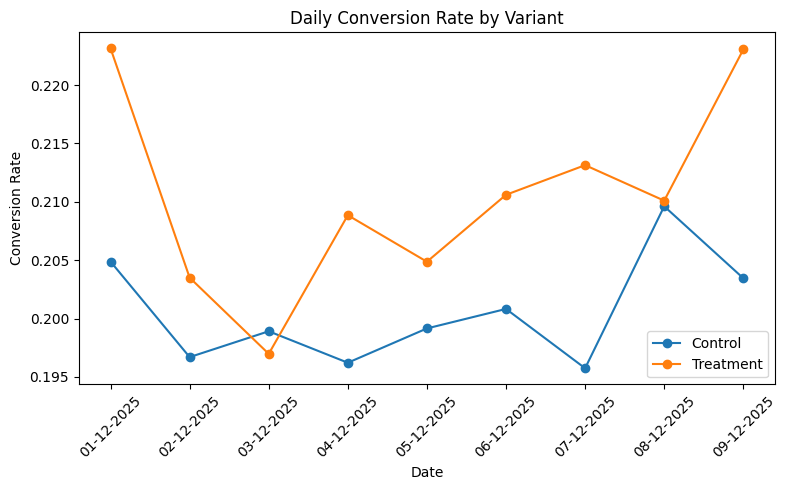

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

for variant in ['control', 'treatment']:
    subset = daily_order_rate[daily_order_rate['variant'] == variant]
    plt.plot(
        subset['date'],
        subset['ordered'],
        marker='o',
        label=variant.capitalize()
    )

plt.title('Daily Conversion Rate by Variant')
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Randomization Validation




In [ ]:
from scipy.stats import chisquare

observed = df['variant'].value_counts().values
expected = [observed.sum()/2, observed.sum()/2]

chi2, p_value = chisquare(f_obs=observed, f_exp=expected)

chi2, p_value


(np.float64(0.007787804404259452), np.float64(0.9296791402709099))

In [ ]:
summary = df.groupby('variant')['ordered'].agg(['sum','count'])
summary

,sum,count
variant,,
control,5675,28303
treatment,5961,28324


## Two-proportion z-test for conversion rate

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

z_stat, p_value = proportions_ztest(
    count=[
        summary.loc['treatment','sum'],
        summary.loc['control','sum']
    ],
    nobs=[
        summary.loc['treatment','count'],
        summary.loc['control','count']
    ],
    alternative='larger'
)

z_stat, p_value


(np.float64(2.9296150820387674), np.float64(0.0016969105827388475))

In [ ]:
control_cr = summary.loc['control','sum'] / summary.loc['control','count']
treatment_cr = summary.loc['treatment','sum'] / summary.loc['treatment','count']

lift = treatment_cr - control_cr
print("Absolute lift:", lift)

Absolute lift: 0.009948782503186426


## Guardrail test

In [ ]:
cancel_df = df[df['ordered'] == 1]

summary_cancel = cancel_df.groupby('variant')['order_cancelled'].agg(['sum','count'])

z_cancel, p_cancel = proportions_ztest(
    count=[
        summary_cancel.loc['treatment','sum'],
        summary_cancel.loc['control','sum']
    ],
    nobs=[
        summary_cancel.loc['treatment','count'],
        summary_cancel.loc['control','count']
    ],
    alternative='two-sided'
)

z_cancel, p_cancel

(np.float64(1.8954489731260555), np.float64(0.058032945835201466))